#LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import re
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
import string
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTETomek
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#BASICS

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab CSVS/Research_tweets_files/Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df.drop(['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord','negativereason','negativereason_confidence','retweet_count','tweet_created','tweet_location','user_timezone','name','tweet_id'], axis = 1, inplace = True)

In [ ]:
df = df.drop(df.query('airline_sentiment_confidence < 0.65').index,axis=0).reset_index(drop=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13663 entries, 0 to 13662
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airline_sentiment             13663 non-null  object 
 1   airline_sentiment_confidence  13663 non-null  float64
 2   airline                       13663 non-null  object 
 3   text                          13663 non-null  object 
dtypes: float64(1), object(3)
memory usage: 427.1+ KB


In [ ]:
df

,airline_sentiment,airline_sentiment_confidence,airline,text
0,neutral,1.0000,Virgin America,@VirginAmerica What @dhepburn said.
1,neutral,0.6837,Virgin America,@VirginAmerica I didn't today... Must mean I n...
2,negative,1.0000,Virgin America,@VirginAmerica it's really aggressive to blast...
3,negative,1.0000,Virgin America,@VirginAmerica and it's a really big bad thing...
4,negative,1.0000,Virgin America,@VirginAmerica seriously would pay $30 a fligh...
...,...,...,...,...
13658,negative,0.6684,American,@AmericanAir right on cue with the delays👌
13659,negative,1.0000,American,@AmericanAir leaving over 20 minutes Late Flig...
13660,neutral,1.0000,American,@AmericanAir Please bring American Airlines to...
13661,negative,1.0000,American,"@AmericanAir you have my money, you change my ..."


In [ ]:
df.drop('airline_sentiment_confidence', axis = 1, inplace = True)

In [ ]:
group_airline = df.groupby('airline')

In [ ]:
df['airline'].unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

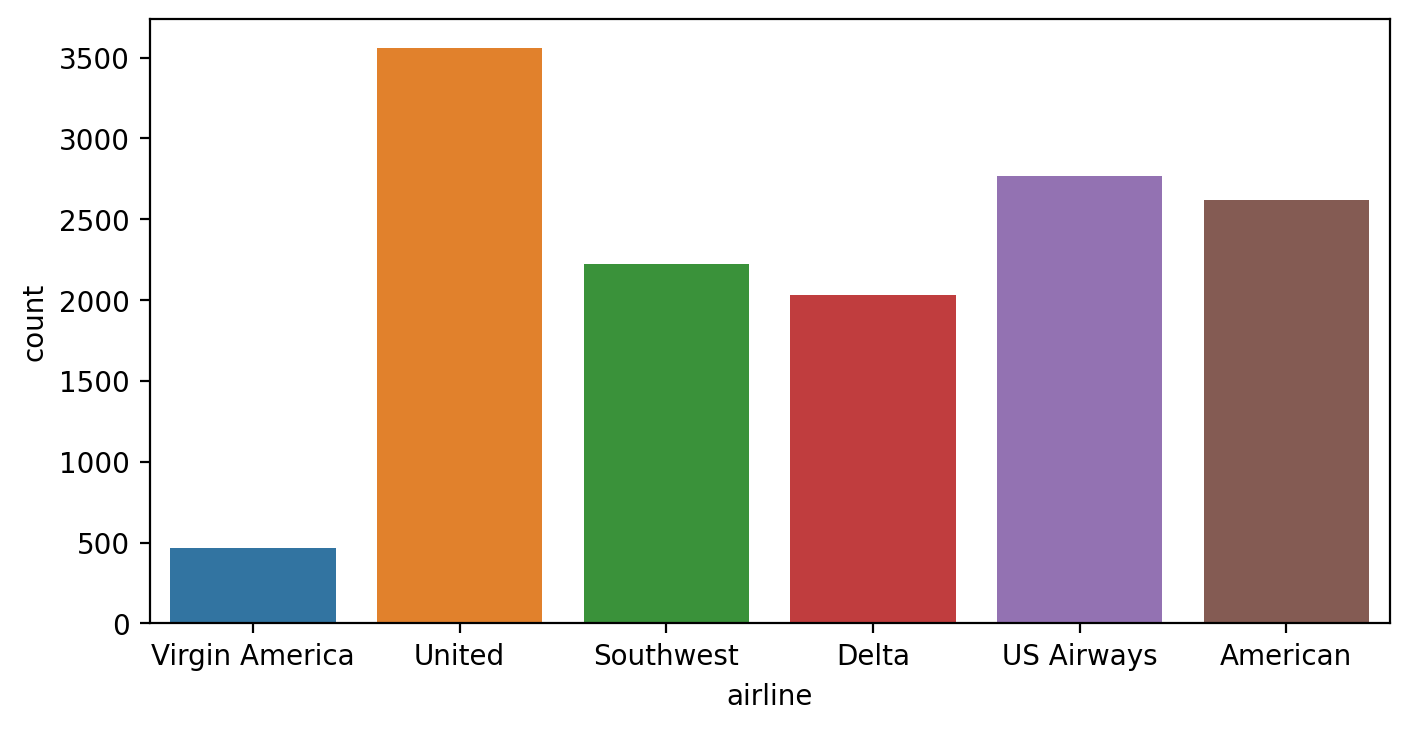

In [ ]:
plt.figure(figsize=(8,4),dpi=200)
sns.countplot(x='airline', data=df)

#PREPROCESSING TEXT COLUMN

In [ ]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

In [ ]:
df['text'] = np.vectorize(remove_pattern)(df['text'], "@[\w]*")

In [ ]:
# df['text'].replace("[^a-zA-Z]", " ", regex=True, inplace=True)

In [ ]:
df['text'][7892]

". thx for confirming! Again, yr team is awesome. Thanks for the prompt &amp; helpful response! Cheers to less snow in everyone's future"

In [ ]:
ps = PorterStemmer()

In [ ]:
extra = ['@','VirginAmerica','united','SouthwestAir','JetBlue','USAirways','AmericanAir','#']
stop = stopwords.words('english')
stop.extend(extra)
stop.extend(string.punctuation)
stop.extend(string.digits)

In [ ]:
def func(x):
        x = x.lower()
        words= nltk.word_tokenize(x)    
        words = [ps.stem(word) for word in words if word not in stop and (len(word)>=3) and (len(word)<=20)]
        return " ".join(words)

In [ ]:
df['text'] = df['text'].apply(func)

In [ ]:
df['text'][7892]

'thx confirm team awesom thank prompt amp help respons cheer less snow everyon futur'

In [ ]:
# wl = WordNetLemmatizer()

In [ ]:
# def func():
#     for i in df.index:
#         words= df['text'][i].lower().split()
#         stops = set(stopwords.words("english"))      
#         meaningful_words = [w for w in words if not w in stops]
#         lemmatized = [wl.lemmatize(word) for word in meaningful_words] 
#         df['text'][i] = " ".join(lemmatized)

In [ ]:
# func()

In [ ]:
df['text']

0                                                     said
1             n't today ... must mean need take anoth trip
2        realli aggress blast obnoxi entertain guest fa...
3                                     realli big bad thing
4        serious would pay flight seat n't play realli ...
                               ...                        
13658                                    right cue delays👌
13659    leav minut late flight warn commun minut late ...
13660             pleas bring american airlin blackberry10
13661    money chang flight n't answer phone suggest ma...
13662    ppl need know mani seat next flight plz put st...
Name: text, Length: 13663, dtype: object

# SPLITING INTO 6

In [ ]:
df_virgin_america = group_airline.get_group('Virgin America')
df_virgin_america.drop('airline', axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_united = group_airline.get_group('United')
# df.united('airline', axis = 1, inplace = True)

In [ ]:
df_southwest = group_airline.get_group('Southwest')
df_southwest.drop('airline', axis = 1, inplace = True)

In [ ]:
df_delta = group_airline.get_group('Delta')
df_delta.drop('airline', axis = 1, inplace = True)

In [ ]:
df_american = group_airline.get_group('American')
df_american.drop('airline', axis = 1, inplace = True)

In [ ]:
df_us_airways = group_airline.get_group('US Airways')
df_us_airways.drop('airline', axis = 1, inplace = True)

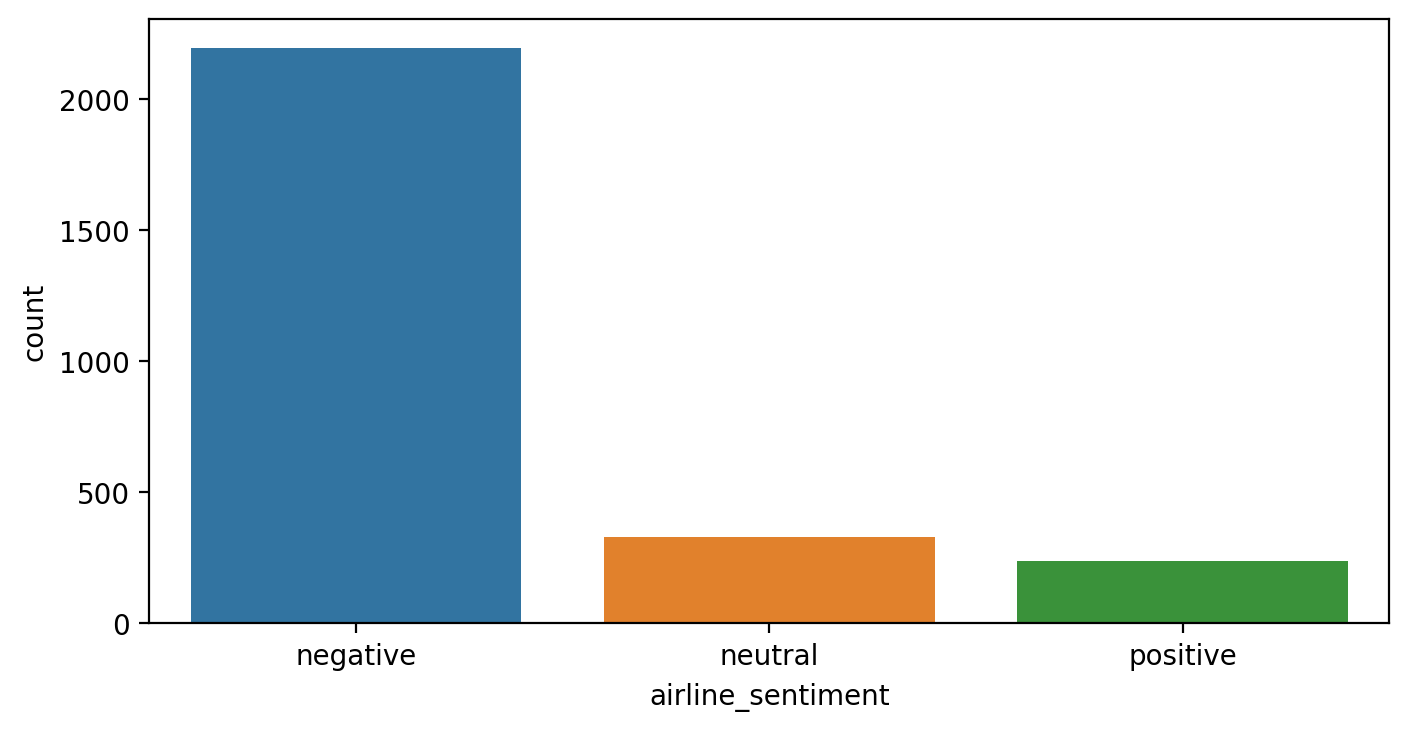

In [ ]:
plt.figure(figsize=(8,4),dpi=200)
sns.countplot(x='airline_sentiment', data=df_us_airways)

#Spliting X and Y

In [ ]:
x = df_us_airways['text']
y = df_us_airways['airline_sentiment']

#TF-IDF TO

In [ ]:
tfidf = TfidfVectorizer()

In [ ]:
x = tfidf.fit_transform(x)

#Balancing

In [ ]:
smk = SMOTETomek()
x_res_new,y_res_new = smk.fit_resample(x,y)

#Train-Test_Split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_res_new, y_res_new, test_size=0.34, random_state=101)

#ML Algos

##RandomForest

In [ ]:
rfc = RandomForestClassifier(n_estimators = 600, random_state = 0)

In [ ]:
rfc.fit(x_train,y_train)

RandomForestClassifier(n_estimators=600, random_state=0)

In [ ]:
rfc_preds = rfc.predict(x_test)

0.9486377847253238


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

    negative       0.96      0.90      0.93       747
     neutral       0.97      0.95      0.96       764
    positive       0.92      0.99      0.95       728

    accuracy                           0.95      2239
   macro avg       0.95      0.95      0.95      2239
weighted avg       0.95      0.95      0.95      2239



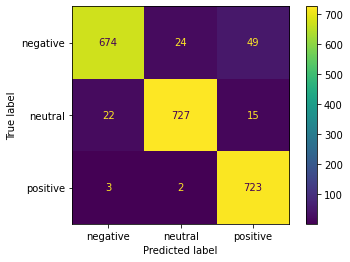

In [ ]:
rfc_score = accuracy_score(y_test, rfc_preds)
print(rfc_score)
rfc_matrix = plot_confusion_matrix(rfc, x_test, y_test)
print(rfc_matrix)
rfc_report = classification_report(y_test, rfc_preds)
print(rfc_report)

WILL HAVE TO APPLY MORE ML ALGORITHMS